# Overview figure

This notebook creates all subfigures related to the first figure in the manuscript.

In [2]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from tqdm.auto import tqdm
import os
import string

sys.path.append("../../")
sys.path.append("../../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from header_plotting import *

%load_ext autoreload
%autoreload 2

In [3]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
countries = ['GB', 'Czechia', 'Spain', 'Italy', 'Slovakia',
       'Germany', 'Austria', 'Belgium', 'France', 'Portugal',
       'Netherlands']

traces,traces_without_soccer,traces_primary_soccer, models, dls = [], [], [], [],[]
for country in tqdm(countries):
    folder="/data.nst/smohr/covid19_soccer_data/main_traces"
    fstr=lambda tune, draws, max_treedepth, folder: (f"{folder}/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    model = None
    tune, draws, max_treedepth = (2000, 4000, 12)
    if os.path.exists(fstr(tune, draws, max_treedepth, folder)):
        model, trace = load(fstr(tune, draws, max_treedepth, folder))
        print(f"Use {draws} sample runs for {country}")

    tune, draws, max_treedepth = (1000, 2000, 12)
    folder="/data.nst/share/soccer_project/covid_uefa_traces15"
    if os.path.exists(fstr(tune, draws, max_treedepth, folder)) and model is None:
        model, trace = load(fstr(tune, draws, max_treedepth, folder))
        print(f"Use {draws} sample runs for {country}")
    tune, draws, max_treedepth = (500, 1000, 12)
    if os.path.exists(fstr(tune, draws, max_treedepth, folder)) and model is None:
        model, trace = load(fstr(tune, draws, max_treedepth, folder))
        print(f"Use {draws} sample runs for {country}")

    if model is None: 
        print(fstr(tune, draws, max_treedepth, folder), " not found")

    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)
    
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_data/primary_and_subsequent/{country}.pkl")

    traces_without_soccer.append(trace_without_soccer)
    traces_primary_soccer.append(trace_primary_soccer)

# Load overall data see overall_effect_Eng_Sct_combined.ipynb
trace_overall = load("/data.nst/smohr/covid19_soccer_data/trace_overall_effekt_Eng_Sct_combined.pkl")
alpha_overall = load("/data.nst/smohr/covid19_soccer_data/trace_overall_alpha_Eng_Sct_combined.pkl")

# Load counterfactual
file = "/data.nst/smohr/covid19_soccer_data/counterfactual/Czechia_with_England_participation.pkl"
(trace_czechia_with_england_participation,
 trace_czechia_with_england_participation_no_soccer,
 trace_czechia_with_england_participation_primary) = load(file)

file = "/data.nst/smohr/covid19_soccer_data/counterfactual/England_only_groupstage.pkl"
trace_only_GS, trace_only_GS_no_soccer, trace_only_GS_primary = load(file)

  0%|          | 0/11 [00:00<?, ?it/s]

Use 2000 sample runs for GB
Use 4000 sample runs for Czechia
Use 4000 sample runs for Spain
Use 4000 sample runs for Italy
Use 4000 sample runs for Slovakia
Use 4000 sample runs for Germany
Use 4000 sample runs for Austria
Use 4000 sample runs for Belgium
Use 4000 sample runs for France
Use 4000 sample runs for Portugal
Use 4000 sample runs for Netherlands


In [4]:
infections_no = []
infections_primary = []
infections_subsequent = []
for i, country in enumerate(countries):
    shape = traces_without_soccer[i].predictions["new_cases"].to_numpy().shape
    x = pd.date_range(models[i].sim_begin, models[i].sim_end)
    y0 = get_from_trace("new_cases",traces_without_soccer[i],from_type="predictions")
    y1 = get_from_trace("new_cases",traces_primary_soccer[i],from_type="predictions") - y0
    y2 = get_from_trace("new_cases",traces[i]) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - models[i].sim_begin).days
    i_end = (end - models[i].sim_begin).days + 1  # inclusiv last day

    y0 = np.sum(y0[..., i_begin:i_end, :], axis=-2)
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=-2)
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=-2)

    infections_no.append(y0)
    infections_primary.append(y1)
    infections_subsequent.append(y2)
    
data_primary  = pd.DataFrame()
medians = []
for i,country in enumerate(countries):
    # compute fraction of infected people
    t_numpy = infections_primary[i] / (infections_no[i] + infections_primary[i] + infections_subsequent[i]) * 100
    print(t_numpy.shape)
    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary = pd.concat([data_primary, temp])
    medians.append(np.median(temp["percentage_primary"]))
country_order_primar = np.argsort(medians)[::-1]

data_primary_and_subsequent = pd.DataFrame()
medians = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = (infections_primary[i]+infections_subsequent[i])/(infections_no[i] + infections_primary[i] + infections_subsequent[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary_and_subsequent", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary_and_subsequent = pd.concat([data_primary_and_subsequent, temp])
    medians.append(np.median(temp["percentage_primary_and_subsequent"]))
country_order_primary_and_subsequent = np.argsort(medians)[::-1]


# Compute interesting values as fraction, as incidence and as cases
primary_frac = []
for i, country in enumerate(countries):
    temp = data_primary[data_primary["country"] == country].drop(columns=["country"])
    temp_m = temp[temp["gender"]=="male"].drop(columns=["gender"])
    temp_f = temp[temp["gender"]=="female"].drop(columns=["gender"])
    primary_frac.append(np.array([temp_m.to_numpy()[:,0],temp_f.to_numpy()[:,0]]))
primary_frac.insert(0,get_from_trace("overall_effect",trace_overall).T) # insert total effect at front

primary_and_subsequent_frac = []
for i, country in enumerate(countries):
    temp = data_primary_and_subsequent[data_primary_and_subsequent["country"] == country].drop(columns=["country","gender"])
    primary_and_subsequent_frac.append(temp.to_numpy()[:,0])

primary_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i]
    primary_inci.append(temp / dls[i].population[0]*1e6)

primary_and_subsequent_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i] + infections_subsequent[i]
    primary_and_subsequent_inci.append(temp/ dls[i].population[0]*1e6)

primary_cases = []
for i, country in enumerate(countries):
    temp = infections_primary[i]
    primary_cases.append(temp)

primary_and_subsequent_cases = []
for i, country in enumerate(countries):
    temp = infections_primary[i] + infections_subsequent[i]
    primary_and_subsequent_cases.append(temp)
    

(16000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(28000, 2)
(32000, 2)
(32000, 2)


In [5]:
from covid19_soccer.plot.other import MulticolorPatch, MulticolorPatchHandler, Line2D, Rectangle, HandlerRect, rcParams
from covid19_soccer.plot.utils import k_formatter, MinorSymLogLocator
import string

def get_xy(trace,trace_without_soccer,trace_primary_soccer):
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    x = pd.date_range(model.sim_begin, model.sim_end)
    y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0)
    y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0) - y0
    y2 = trace.posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0) - y1 - y0
    
    y = [
        y0[:,0]+y0[:,1],
        y1[:,0]+y1[:,1],
        y2[:,0]+y2[:,1]
    ]
    return x, y
def plot_legend(ax,loc="upper left",data=False,model=False,primary=True):
    """ Plot the legend onto an axis
    Parameters
    ----------
    ax: mpl axis
    loc: strin
        Location of the legend
    """
    # Legend
    handles = []
    labels = []
    if data:
        handles.append(Line2D(
                    [0],
                    [0],
                    color="black",
                    ls="none",
                    lw=0,
                    marker="d",
                    ms=3.5
                ))
        labels.append("Observed\ncases") 
    if model:
        handles.append(
            Line2D(
                [0],
                [0],
                color=rcParams.color_model,
                lw=2,
            )
        )
        labels.append("Model")
    
    """
    handles.append(MulticolorPatch([colors_base[1]]))
    labels.append("Source of\ninfection:")
    """
    if primary:
        handles.append(MulticolorPatch([colors_base[1]]))
        labels.append("Primary\ncases")

        handles.append(MulticolorPatch([colors_base[2]]))
        labels.append("Subsequent\ncases")

        handles.append(MulticolorPatch([colors_base[0]]))
        labels.append("Independent\ncases")

    #handles.append(Rectangle([0,0],width=1, height=2.2, lw=1, edgecolor=rcParams.color_championship_range,hatch="////",facecolor = 'none'))
    #labels.append("Time window of\nthe championship") 

    ax.legend(
        handles,
        labels,
        handler_map={MulticolorPatch: MulticolorPatchHandler(), Rectangle: HandlerRect(),},
        loc=loc,
    )
    return ax


def get_primary_and_subsequent(trace,trace_without_soccer,trace_primary_soccer):
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    y0 = get_from_trace("new_cases",trace_without_soccer,from_type="predictions")
    y1 = get_from_trace("new_cases",traces_primary_soccer[i],from_type="predictions") - y0
    y2 = get_from_trace("new_cases",trace) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - model.sim_begin).days
    i_end = (end - model.sim_begin).days + 1  # inclusiv last day

    
    y0 = np.sum(y0[..., i_begin:i_end, :], axis=(-2,-1)) #no soccer
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=(-2,-1)) #primary
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=(-2,-1)) #subsequent

    return y1+y2 

def whisker_plot_v(ax,x,y_median,y_lower_95,y_upper_95,y_lower_68,y_upper_68):
    lines = ax.vlines(
        x=x,
        ymin=y_lower_95,
        ymax=y_upper_95,
        lw=1.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines = ax.vlines(
        x=x,
        ymin=y_lower_68,
        ymax=y_upper_68,
        lw=2.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines.set_capstyle("round")
    ax.scatter(
        x=x,
        y=y_median,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )
    ax.axhline(0, color="tab:gray", ls="--", zorder=-10)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(axis="y",bottom=False)



## Part2: Violins and totals


In [6]:
from covid19_soccer.plot.utils import k_formatter, MinorSymLogLocator
import string

def reduce_samples(curr_list):
    number_of_samples = 4000
    temp = []
    for i, array in enumerate(curr_list):
        array = array[np.random.choice(array.shape[0], number_of_samples, replace = False),...]
        temp.append(array)
    return np.array(temp)

def whisker_plot(ax,y,x_median,x_lower_95,x_upper_95,x_lower_68,x_upper_68):
    lines = ax.hlines(
        y=y,
        xmin=x_lower_95,
        xmax=x_upper_95,
        lw=1.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines = ax.hlines(
        y=y,
        xmin=x_lower_68,
        xmax=x_upper_68,
        lw=2.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines.set_capstyle("round")
    ax.scatter(
        y=y,
        x=x_median,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )
    ax.axvline(0, color="tab:gray", ls="--", zorder=-10)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(False)
    ax.set_yticklabels([])
    ax.tick_params(axis="y",left=False)

In [40]:
# Layout
gridspec = { # Layout
    "wspace": 0.15,
    "width_ratios":[1,1.618,1],
}
fig, axes  = plt.subplots(1, 3, figsize=(7,3.5), gridspec_kw=gridspec)
#grid = fig.add_gridspec(2, 1, hspace=0.28, height_ratios=[3,2],)

#ax1 = fig.add_subplot(grid[0, 0])
#ax2 = fig.add_subplot(grid[1, 0])
#ax3 = fig.add_subplot(outer_grid[0, 1])
X = [dls[i].countries_iso2[0].replace("GB-","") for i, country in enumerate(countries)]
X.insert(0, "Avg.")


In [41]:
from covid19_soccer.plot.rcParams import *

ax0 = axes[0]

# Plot overall first
dat = get_from_trace("overall_alpha",alpha_overall)
m,l2,l1,u1,u2 = np.percentile(dat,q=(50,2.5,50-34,50+34,97.5))
whisker_plot(ax0,"Avg.",m,l2,u2,l1,u1)

for i, (trace, country) in enumerate(zip(traces,countries)):
    # Get datapoints
    dat = get_from_trace("alpha_mean",trace)
    
    m,l2,l1,u1,u2 = np.percentile(dat,q=(50,2.5,50-34,50+34,97.5))

    whisker_plot(ax0,country,m,l2,u2,l1,u1)

ax0.set_ylim(11.6,-1.1)
ax0.set_xlabel("Mean match effect\n$\Delta R_\mathrm{match}^\mathrm{mean}$")
ax0.axvline(0,ls="--",color="tab:gray")
ax0.set_yticklabels([]);
ax0.set_xticks([-2.5,0,2.5,5])

In [42]:
from covid19_soccer.plot.other import soccer_related_cases_overview, vviolins
ax1 = axes[1]


vviolins(
        ax1,
        countries,
        primary_frac,
)

ci = [np.percentile(pf,q = (2.5,50,97.5,50-34,50+34)) for pf in primary_frac]
ci = np.array(ci).T
whisker_plot(ax1,X,ci[1,:],ci[0,:],ci[2,:],ci[3,:],ci[4,:])
print(ci)

ax1.set_xlim(-20,29)
ax1.set_ylim(11.6,-1.1)
ax1.tick_params(axis="y", which="major", pad=16, length=0)

ax1.set_xlabel("Primary cases (% of all observed\ncases, from 11th June to 31st July) ")


# Add legend
from covid19_soccer.plot.other import legend

legend(
    ax=ax1,
    prior=False,
    posterior=False,
    model=False,
    data=False,
    sex=True,
    disable_axis=False,
    championship_range=False,
    loc="lower right",
)

[[-0.13883714  3.60107266  3.31616095 -1.10056529 -5.7614399  -7.66324737
  -1.83752082 -2.23548779 -2.31430799 -0.1523841  -2.57400605 -3.25109686]
 [ 2.94320307 10.75798009  9.70144159  2.83119775  2.1323913   1.56913254
   1.38144474  1.1840508   0.55652488  0.51215963  0.26781116 -1.46212308]
 [ 6.88713175 21.78204812 16.24490825  9.2241272  10.86213096 10.2136499
   4.2275368   4.80766422  4.22500201  1.35144941  2.65817755 -0.17212014]
 [ 1.57928665  6.65302097  6.49698431  0.78050901 -1.24436849 -1.46501327
   0.16697613 -0.2513079  -0.69140298  0.17503512 -0.83755582 -2.34475985]
 [ 4.79665689 16.66248218 12.95123925  5.68168539  6.08868496  5.32701651
   2.79307178  2.85835633  2.10500813  0.9172402   1.33948415 -0.72012818]]


/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1259: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=0,),)
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1263: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=0,),)


<AxesSubplot:xlabel='Primary cases (% of all observed\ncases, from 11th June to 31st July) ', ylabel='country'>

In [43]:
from covid19_soccer.plot.other import plot_flags

X = [dls[i].countries_iso2[0].replace("GB-","") for i, country in enumerate(countries)]
X.insert(0, "Avg.")

plot_flags(
    ax1,
    X,
    vertical=True,
    zoom=0.019,
    ypos_flags=-20,
    adjust_align=-32.5
)

lookup_games_played = {
    "Avg.":"‒",
    "GB": 9,
    "CZ":5,
    "ES":6,
    "IT":7,
    "SK":3,
    "DE":4,
    "AT":4,
    "BE":5,
    "FR":4,
    "PT":4,
    "NL":4
}
y_labels = [f"{x}       ({lookup_games_played[x]})" for x in X]
ax1.set_ylabel(None)

ax1.set_yticks(list(range(12)))
ax1.set_yticklabels(y_labels)

[Text(0, 0, 'Avg.       (‒)'),
 Text(0, 1, 'GB       (9)'),
 Text(0, 2, 'CZ       (5)'),
 Text(0, 3, 'ES       (6)'),
 Text(0, 4, 'IT       (7)'),
 Text(0, 5, 'SK       (3)'),
 Text(0, 6, 'DE       (4)'),
 Text(0, 7, 'AT       (4)'),
 Text(0, 8, 'BE       (5)'),
 Text(0, 9, 'FR       (4)'),
 Text(0, 10, 'PT       (4)'),
 Text(0, 11, 'NL       (4)')]

[ 734.42864825 2248.29008712 3392.27573331 1557.93068155 2844.46668114]


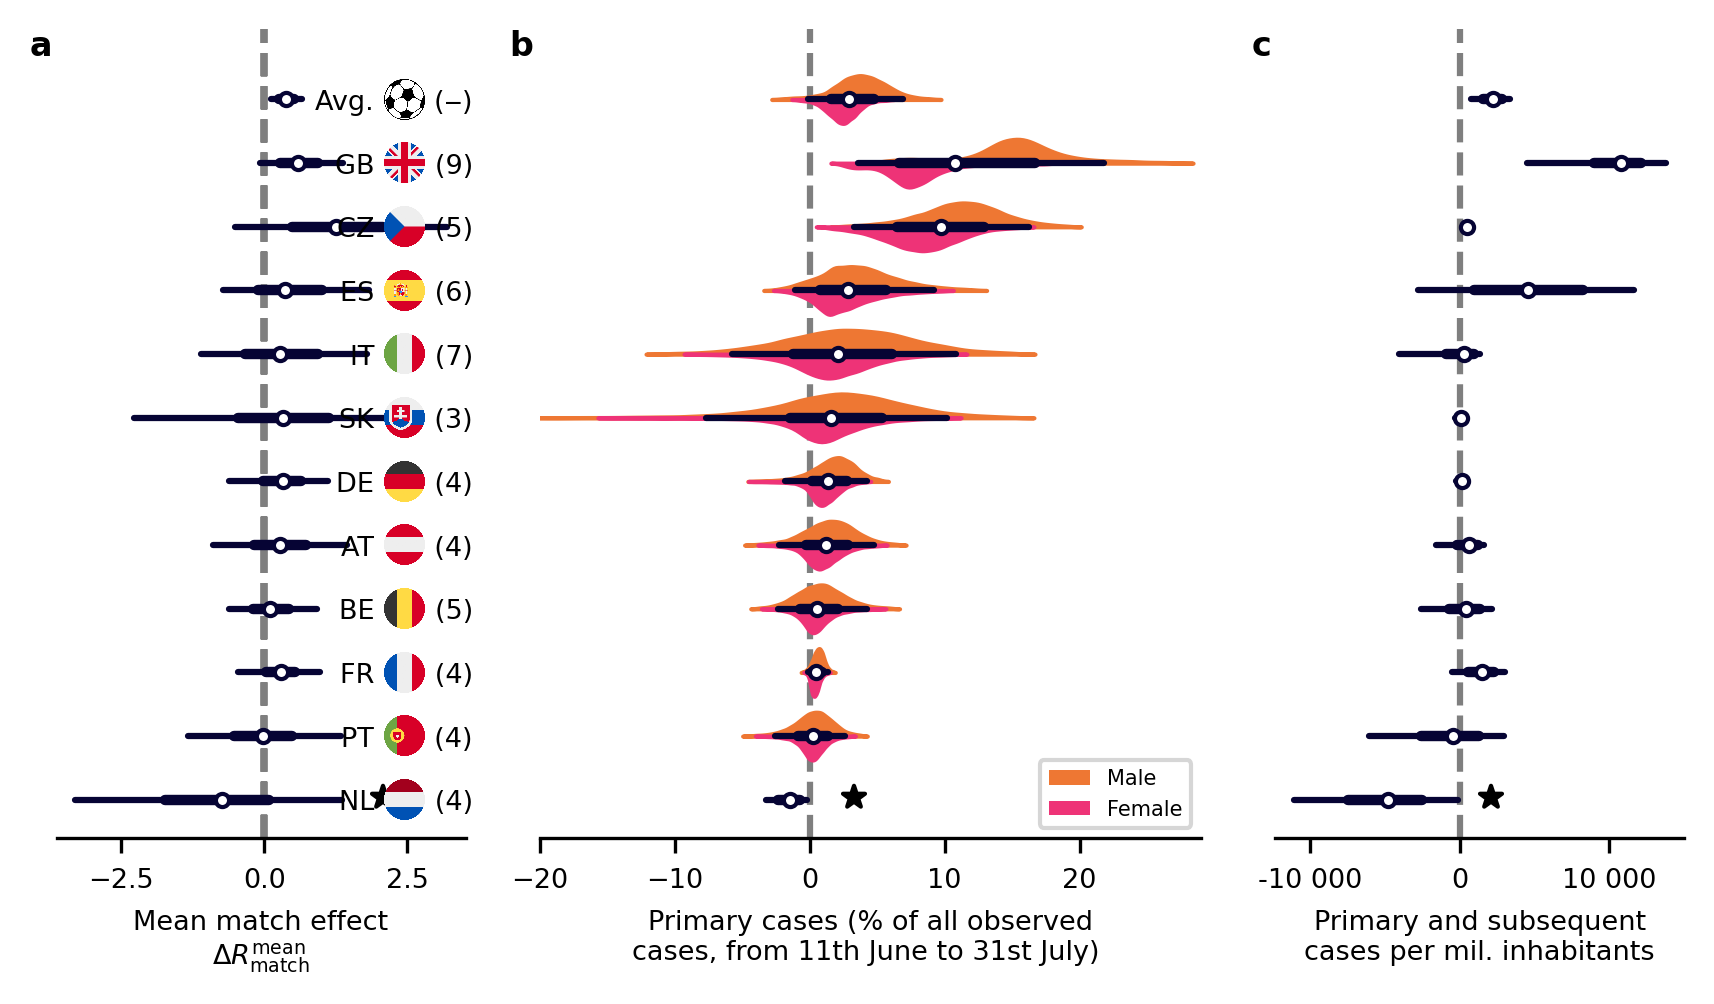

In [44]:
ax2 = axes[2]

Y = reduce_samples(primary_and_subsequent_cases).sum(axis=-1) # shape 12,n
population = np.array([dls[i].population.sum() for i,c in enumerate(countries)])

total = np.percentile(Y.sum(axis=0)/population.sum()*1e6,q=(2.5,50,97.5,50-34,50+34),axis=0)
Y = np.percentile(Y,q = (2.5,50,97.5,50-34,50+34),axis=-1) / population * 1e6

X = [dls[i].countries_iso2[0].replace("GB-","") for i, country in enumerate(countries)]
Y = np.insert(Y, 0, total ,axis=1) # Total avg
X.insert(0, "Avg.")
print(total)
whisker_plot(ax2,X,Y[1,:],Y[0,:],Y[2,:],Y[3,:],Y[4,:])

ax2.spines["bottom"].set_visible(True)
ax2.spines["left"].set_visible(False)
ax2.set_yticklabels([])
ax2.tick_params(axis="y",left=False)

#ax2.set_yscale('symlog', linthresh=1e2,base=100)
#ax2.set_yticks([-1e4,-1e2,0,1e2,1e4,1e6])
#ax2.yaxis.set_minor_locator(MinorSymLogLocator(1e2))
#ax2.set_ylim(-1e5,1e5)

def formatter(x,pos):
    if x > 1000 or x < -1000:
        return '{:,.0f}'.format(x).replace(',', ' ')
    else:
        return '{:,.0f}'.format(x)
ax2.xaxis.set_major_formatter(formatter)
ax2.set_ylim(11.6,-1.1)
ax2.set_xlabel("Primary and subsequent\ncases per mil. inhabitants")

# Add star to NL
ax0.scatter(2,"Netherlands",marker='$\star$',color="black",s=50)
ax1.scatter(3,11,marker='$\star$',color="black",s=50)
ax2.scatter(1800,11,marker='$\star$',color="black",s=50)

 # Axis labels
alphabet_string = list(string.ascii_lowercase)
for i in range(3):
    letter = alphabet_string[i]
    axes[i].text(
        -0.01,
        1.0,
        letter,
        transform=axes[i].transAxes,
        fontsize=8,
        fontweight="bold",
        va="top",
        ha="right",
    )       
        
plt.show()
fig.savefig(f"../../figures/overview_frac_primAndSubs_Eng_Sct_combined.pdf", **save_kwargs)
fig.savefig(f"../../figures/overview_frac_primAndSubs_Eng_Sct_combined.png", **save_kwargs)
plt.close()

In [45]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Oct 17 2022

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.24.1

covid19_inference: 0.3.6
pandas           : 1.2.4
seaborn          : 0.11.1
sys              : 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05) 
[GCC 9.3.0]
numpy            : 1.20.3
matplotlib       : 3.5.1

Watermark: 2.3.1

